In [10]:
!pip install openai==1.14.2

# Imports

In [11]:
import io
import re
import os
import json
import base64

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from openai import OpenAI

# Constant

In [12]:
# Env variables
os.environ["OPEN_API_KEY"] = "<OPEN-AI-KEY>"

# File Paths
CLEANED_DATA_PATH = '/kaggle/input/rta-dubai/sample_clean_application_data_2.xlsx'
UNCLEANED_DATA_PATH = '/kaggle/input/rta-dubai/sample_unclean_application_data_v2.xlsx'
METADATA_PATH = '/kaggle/input/rta-dubai/Application dataset.json'

OPEN_AI_CLIENT = OpenAI(api_key=os.getenv("OPEN_API_KEY") ,organization='org-2EugvoZZidKLd5DkFH3dGTIA')

# Models

In [13]:
class MetaData:
    def __init__(self, data):
        self.__dict__ = data

# Helper Function

In [45]:
def load_json_and_map_to_class(json_path):
    try:
        with open(json_path, 'r') as json_file:
            data = json.load(json_file)
            return MetaData(data)
    except json.JSONDecodeError:
        print(f"Error: Unable to decode JSON from file '{file_path}'. File may be empty or not in valid JSON format.")
        return None


def extract_column_attributes_for_column_name_mapping(metadata_json):
    columns_meta_data = []
    for column in metadata_json.attributes:
        columns_meta_data.append({
            "name": column['attribute_name'],
            "description": column['description'], 
            "synonyms": column['synonyms']
        })
    return json.dumps(columns_meta_data)


def convert_dataframe_to_html(dataframe):
    html_string = dataframe.to_html()
    return html_string.replace('\n', '')


def extract_python_code(sample_string):
    # Define a regular expression pattern to match Python code blocks
    pattern = r'```python\n(.*?)```'

    # Find all matches of the pattern in the sample string
    matches = re.findall(pattern, sample_string, re.DOTALL)

    # Return the Python code blocks found
    return matches


def convert_column_types_and_map_values_wrt_metadata(metadata_json, dataframe):
    for column in metadata_json.attributes:
        if column['attribute_name'] in dataframe.columns:
            if column['data_type'].lower() == "string":
                dataframe[column["attribute_name"]] = dataframe[column["attribute_name"]].astype(str)
            elif column['data_type'].lower() == "enum":
                # Check if enum value transformation required
                if column['is_transformation_required']:
                    dataframe[column["attribute_name"]] = dataframe[column["attribute_name"]].astype(str).str.lower().map(column['values'])
                dataframe[column["attribute_name"]] = dataframe[column["attribute_name"]].astype('category')
            elif column['data_type'].lower() == "date":
                dataframe[column["attribute_name"]] = dataframe[column["attribute_name"]].astype('datetime64[ns]')
                
    return dataframe


def check_if_any_new_column_formation_is_required(dataframe, metadata_json):
    new_columns_data = []
    for column in metadata_json.attributes:
        if (column['attribute_name'] not in dataframe) and column['constraints']:
            column_name = column['attribute_name']
            column_type = column['data_type']
            column_desc = column['constraints'][0]
            new_columns_data.append((column_name, column_type, column_desc))
    return new_columns_data


def extract_df_column_names(dataframe):
    return ", ".join(dataframe.columns.tolist())


def extract_df_column_names_with_datatypes(dataframe):
    columns_data_types = {col: str(dtype) for col, dtype in dataframe.dtypes.items()}
    json_data = json.dumps(columns_data_types)
    return json_data


def execute_python_script(python_script):
    slice_script = python_script[9:-3]
    exec(slice_script)
    

def read_saved_dataframe_output():
    with open('output.txt', 'r') as file:
        html_content = file.read()

    return html_content


def read_saved_plot_output():
    with open('output.png', 'rb') as img_file:
        img_base64 = base64.b64encode(img_file.read()).decode('utf-8')
    return img_base64


def read_saved_dataframe_new_col_output():
    with open('dataframe.txt', 'r') as file:
        html_content = file.read()

    # Parse HTML content and convert to DataFrame
    # [TODO] Later remove this, as only for notebook perspective
    return pd.read_html(html_content)[0]


def contains_visual_keywords(text):
    visual_keywords = ['plot', 'graph', 'chart', 'visualization']
    pattern = re.compile(r'\b(?:' + '|'.join(visual_keywords) + r')\b', flags=re.IGNORECASE)
    return True if re.search(pattern, text) else False


def get_html_tag_for_base64_image(img_base64):
    return f'<img src="data:image/png;base64,{img_base64}" style="max-width: 100%; max-height: 100%;" alt="output">'


def get_dataframe_dtypes_metadata(dataframe):
    column_types = {col: str(dataframe[col].dtype) for col in df.columns}
    return json.dumps(column_types)


def load_finalised_csv_dtypes_metadata():
    with open('finalised_metadata.json', 'r') as json_file:
        return json.load(json_file)

    
def show_saved_output_img():
    img = mpimg.imread('output.png')
    img_height, img_width, _ = img.shape
    aspect_ratio = img_width / img_height
    fig_width = 10  # Set a default width
    fig_height = fig_width / aspect_ratio
    fig = plt.figure(figsize=(fig_width, fig_height))
    plt.imshow(img, interpolation='nearest')
    plt.axis('off')
    plt.tight_layout()
    # return fig  # Return the figure object

# OpenAI Utils

In [15]:
class RTA_Bot:
    _instance = None

    def __new__(cls, *args, **kwargs):
        if not cls._instance:
            cls._instance = super().__new__(cls, *args, **kwargs)
        return cls._instance

    @staticmethod
    def ask(prompt):
        return OPEN_AI_CLIENT.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
            {
                "role": "user",
                "content": prompt,
            }],
        ).choices[0].message.content

In [43]:
def map_column_names_wrt_meta_data(dataset_column_names, metadata_json):
    prompt = f"""
Role: Act as a data analyst whose job is to help in transforming the dataset.
Task: Consider below defined "dataset_column_names". Look up the "columns_meta_data_json" and pick relevant column attribute_name w.r.t to the attribute description and synonyms context. Output should be a json with key as 'dataset_column_names' and value as attribute_name picked from columns_meta_data_json

dataset_column_names: {dataset_column_names}

columns_meta_data_json: 
{extract_column_attributes_for_column_name_mapping(metadata_json)}

Output: Return output in JSON Format defined under sample output.

Sample Output: {{"Column1 Old Name": "Column1 New Name", "Column2 Old Name": "Column2 New Name", ...}}
"""
    response = RTA_Bot.ask(prompt)
    return json.loads(response)


def ask_rta_bot(question):
    column_names = load_finalised_csv_dtypes_metadata()
    
    if contains_visual_keywords(question):
        execute_visual_prompt(question,column_names)
    else:
        output_dataframe = execute_dataframe_prompt(question, column_names)
        return output_dataframe


def execute_dataframe_prompt(question, column_names):
    prompt = f""" 
Role: Act as a data analyst whose job is to extract insights from the dataset based on the users asked questions.

Task: Write a valid Python script for the below-mentioned "user_question". Load "finalised.csv" only for querying the data.

user_question: {question}

"finalised.csv" pandas columns names and their types: {column_names}

output: The output should only be a valid python script

Script steps:
1. Read .csv file named 'finalised.csv'
2. Convert the data types of the above read 'finalised.csv' dataframe as per the datatypes defined above
3. Code for the task
4. Form a pandas dataframe of the final output
5. Then convert output dataframe into html string
6. Save the output into a file named 'output.txt'
"""
    print(prompt)
    try:
        # Generate response
        python_script = RTA_Bot.ask(prompt)
        print(python_script)

        # Execute script
        execute_python_script(python_script)

        # Read output dataframe as html table tag
        output = read_saved_dataframe_output()

        # Remove file
        # os.remove('output.txt')

        # Return output
        return output
    except Exception as e:
        print("I apologize, but I'm currently unable to fulfill your request. Could you please try again or provide me more details to assist me in better understanding your request?")
        print(e)
        return None
    
    
def execute_visual_prompt(question, column_names):
    prompt = f""" 
Role: Act as a data analyst whose job is extract insights from the dataset based on the users asked question.

Task: Write a valid python script for the below mentioned "user_question". Load "finalised.csv" only for querying the data.

user_question: {question}

"finalised.csv"  pandas columns names and their types: {column_names}

output: The output should only be a valid python script

Script steps:
1. Read .csv file named 'finalised.csv'
2. Convert the data types of the above read 'finalised.csv' dataframe as per the datatypes defined above
3. Code for the user's asked question.
4. Form a plot as the final output, no need to write plt.show() code.
5. Save the output plot as a .png file named 'output.png'
"""
    print(prompt)
    try:
        # Generate response
        python_script = RTA_Bot.ask(prompt)
        print(python_script)

        # Execute script
        execute_python_script(python_script)

        # Read output image as html image tag
        output = get_html_tag_for_base64_image(read_saved_plot_output())
        
        # [REMOVE]
        # show_saved_output_img()
        
        # Remove file
        # os.remove('output.png')

        # Return output
        return output
        
    except Exception as e:
        print("I apologize, but I'm currently unable to fulfill your request. Could you please try again or provide me more details to assist me in better understanding your request?")
        print(e)
        return None

def execute_create_new_column_prompt(new_column, existing_df_columns_metadata):
    new_column_name = new_column[0]
    new_column_type = new_column[1]
    new_column_desc = new_column[2]
    
    prompt = f"""
Role: Act as a data analyst whose job is to create new columns from the below defined 'finalised.csv' data columns names and their data types.

Task: Write a valid python script for the below mentioned "user_question". Use 'finalised.csv' only for querying the data.

user_question: Create a new column named "{new_column_name}" with type {new_column_type} and constraints as {new_column_desc}.

existing pandas columns names and their types: {existing_df_columns_metadata}

Script steps:
1. Read .csv file named 'finalised.csv'
2. Convert the data types of the above read 'finalised.csv' dataframe as per the datatypes defined above
3. Code for the task.
4. Form a pandas dataframe of the final output with newly added column and its supporting column.
5. Then convert output dataframe into html string
6. Save the output into a file named 'dataframe.txt'

    """
    try:
        # Generate response
        python_script = RTA_Bot.ask(prompt)
        print(python_script)
        
        # Execute script
        execute_python_script(python_script)

        # Read output dataframe as html table tag
        output = read_saved_dataframe_new_col_output()

        # Remove file
        # os.remove('dataframe.txt')

        # Return output
        return output
    except Exception as e:
        print("--------Error in new column formation--------")
        print(prompt)
        print(e)
        return None


# Pipeline

1. Extract **unclean dataset column names** and **attributes objects** from the meta-data.
2. Use Open-AI to map **column new names** w.r.t to the provided meta-data.
3. Change columns names.
4. Transform columns types and their values w.r.t to the **metadata**
5. Check if new columns formation is left w.r.t to the **metadata**
6. Talk with the transformed dataset


# Code

In [26]:
def execute_pipline():
    # -------------------------------------------------------
    # 1. Read the un-cleaned dataset and metadata json
    # -------------------------------------------------------
    df_uncleaned = pd.read_excel(UNCLEANED_DATA_PATH)
    metadata_json = load_json_and_map_to_class(METADATA_PATH)
    
    
    # -------------------------------------------------------
    # 2. Column name mapping w.r.t metadata json
    # -------------------------------------------------------
    # Extract old column names
    uncleaned_column_old_names = ','.join(df_uncleaned.columns)

    # Use Open-Ai to map new column names w.r.t to context
    uncleaned_column_new_names = map_column_names_wrt_meta_data(uncleaned_column_old_names, metadata_json)

    # Rename columns
    df_uncleaned.rename(columns=uncleaned_column_new_names, inplace=True)

    
    # -------------------------------------------------------
    # 3. Convert column type w.r.t metadata json
    # -------------------------------------------------------
    df_uncleaned = convert_column_types_and_map_values_wrt_metadata(metadata_json, df_uncleaned)
    df_uncleaned.to_csv('finalised.csv', index=False)
    with open('finalised_metadata.json', "w") as json_file:
        json.dump(get_dataframe_dtypes_metadata(df_uncleaned), json_file)
    

    # -------------------------------------------------------
    # 4. Add new column if any missing w.r.t metadatajson
    # -------------------------------------------------------
    # Extract new columns data
#     new_columns = check_if_any_new_column_formation_is_required(df_uncleaned, metadata_json)
    
#     # Create new columns
#     for new_column in new_columns:
#         new_column_name = new_column[0]
#         new_column_df = execute_create_new_column_prompt(
#             new_column,
#             extract_df_column_names_with_datatypes(df_uncleaned)
#         )
#         # Concatenates column to the main dataset & remove duplicates column wise
#         if new_column_name in new_column_df.columns:
#             df_uncleaned = pd.concat([df_uncleaned, new_column_df], axis=1)
#             df_uncleaned = df_uncleaned.loc[:,~df_uncleaned.columns.duplicated()]
#             df_uncleaned = df_uncleaned.loc[:, ~df_uncleaned.columns.str.contains('^Unnamed')]
    
#     # -------------------------------------------------------
#     # 5. Save modified dataset
#     # -------------------------------------------------------
#     df_uncleaned.to_csv('finalised.csv', index=False)
#     with open('finalised_metadata.json', "w") as json_file:
#         json.dump(get_dataframe_dtypes_metadata(df_uncleaned), json_file)


# Execution

In [27]:
%%time

try:
    execute_pipline()
    print("Execution successfull")
except Exception as e:
    print("Execution failed: ", e)

Execution successfull
CPU times: user 180 ms, sys: 2.62 ms, total: 182 ms
Wall time: 5.49 s


In [28]:
df = pd.read_csv('finalised.csv')
df.head(2)

,Name,Short Name,Description,Business Owner,Technical Owner,Number of Users,Recovery Point Objective,Recovery Time Objective,Go Live Date,End of Support Date,...,System Hosting Place,User Community,Type of System,Enterprise Level,Development Type,Recommendation,Cloud Migration Strategy,Architecture Type,Mobile Compliance,Multi Language Support
0,IBM Maximo,IBM Maximo,A comprehensive enterprise asset management (E...,Strategic Planning,Human Resources,415,NaN,NaN,2016-06-30,2023-06-30,...,Cloud,Both,System of Record,No,COTS,Migrate,Retain,Mainframe,Not Supported,Yes
1,Adobe Experience Manager,AEM,A digital asset management (DAM) system that h...,Strategic Planning,Logistics and Supply Chain,3000,60 mins,Zero data loss,2022-01-01,2024-11-30,...,On Premise,Internal,System of Record,Yes,COTS,Retire,Retire,Mainframe,Not Supported,Yes


In [29]:
with open('finalised_metadata.json', 'r') as json_file:
    data = json.load(json_file)
    print(data)

{"Name": "object", "Short Name": "object", "Description": "object", "Business Owner": "category", "Technical Owner": "category", "Number of Users": "object", "Recovery Point Objective": "object", "Recovery Time Objective": "object", "Go Live Date": "datetime64[ns]", "End of Support Date": "datetime64[ns]", "SLA Type": "category", "Vendor": "category", "Status": "category", "AGF Classification": "category", "DR Type": "category", "Required Availability": "category", "System Hosting Place": "category", "User Community": "category", "Type of System": "category", "Enterprise Level": "category", "Development Type": "category", "Recommendation": "category", "Cloud Migration Strategy": "category", "Architecture Type": "category", "Mobile Compliance": "category", "Multi Language Support": "category"}


In [47]:
ask_rta_bot('What is the User Community percentage w.r.t to its unique values')

 
Role: Act as a data analyst whose job is to extract insights from the dataset based on the users asked questions.

Task: Write a valid Python script for the below-mentioned "user_question". Load "finalised.csv" only for querying the data.

user_question: What is the User Community percentage w.r.t to its unique values

"finalised.csv" pandas columns names and their types: {"Name": "object", "Short Name": "object", "Description": "object", "Business Owner": "category", "Technical Owner": "category", "Number of Users": "object", "Recovery Point Objective": "object", "Recovery Time Objective": "object", "Go Live Date": "datetime64[ns]", "End of Support Date": "datetime64[ns]", "SLA Type": "category", "Vendor": "category", "Status": "category", "AGF Classification": "category", "DR Type": "category", "Required Availability": "category", "System Hosting Place": "category", "User Community": "category", "Type of System": "category", "Enterprise Level": "category", "Development Type": "cate

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>User Community</th>\n      <th>Percentage</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <td>Internal</td>\n      <td>61.904762</td>\n    </tr>\n    <tr>\n      <td>Both</td>\n      <td>21.428571</td>\n    </tr>\n    <tr>\n      <td>External</td>\n      <td>16.666667</td>\n    </tr>\n  </tbody>\n</table>'

In [48]:
ask_rta_bot('Check for data quality issues which should include missing values, unique values, duplicate values and their data types')

 
Role: Act as a data analyst whose job is to extract insights from the dataset based on the users asked questions.

Task: Write a valid Python script for the below-mentioned "user_question". Load "finalised.csv" only for querying the data.

user_question: Check for data quality issues which should include missing values, unique values, duplicate values and their data types

"finalised.csv" pandas columns names and their types: {"Name": "object", "Short Name": "object", "Description": "object", "Business Owner": "category", "Technical Owner": "category", "Number of Users": "object", "Recovery Point Objective": "object", "Recovery Time Objective": "object", "Go Live Date": "datetime64[ns]", "End of Support Date": "datetime64[ns]", "SLA Type": "category", "Vendor": "category", "Status": "category", "AGF Classification": "category", "DR Type": "category", "Required Availability": "category", "System Hosting Place": "category", "User Community": "category", "Type of System": "category", "E

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>Missing Values</th>\n      <th>Unique Values</th>\n      <th>Duplicate Values</th>\n      <th>Data Types</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>Name</th>\n      <td>0</td>\n      <td>98</td>\n      <td>0</td>\n      <td>object</td>\n    </tr>\n    <tr>\n      <th>Short Name</th>\n      <td>0</td>\n      <td>97</td>\n      <td>0</td>\n      <td>object</td>\n    </tr>\n    <tr>\n      <th>Description</th>\n      <td>0</td>\n      <td>100</td>\n      <td>0</td>\n      <td>object</td>\n    </tr>\n    <tr>\n      <th>Business Owner</th>\n      <td>0</td>\n      <td>20</td>\n      <td>0</td>\n      <td>category</td>\n    </tr>\n    <tr>\n      <th>Technical Owner</th>\n      <td>0</td>\n      <td>19</td>\n      <td>0</td>\n      <td>category</td>\n    </tr>\n    <tr>\n      <th>Number of Users</th>\n      <td>44</td>\n      <td>48</td>\n      <td>0</td>\n    

 
Role: Act as a data analyst whose job is extract insights from the dataset based on the users asked question.

Task: Write a valid python script for the below mentioned "user_question". Load "finalised.csv" only for querying the data.

user_question: Plot Pie chart of Status

"finalised.csv"  pandas columns names and their types: {"Name": "object", "Short Name": "object", "Description": "object", "Business Owner": "category", "Technical Owner": "category", "Number of Users": "object", "Recovery Point Objective": "object", "Recovery Time Objective": "object", "Go Live Date": "datetime64[ns]", "End of Support Date": "datetime64[ns]", "SLA Type": "category", "Vendor": "category", "Status": "category", "AGF Classification": "category", "DR Type": "category", "Required Availability": "category", "System Hosting Place": "category", "User Community": "category", "Type of System": "category", "Enterprise Level": "category", "Development Type": "category", "Recommendation": "category", "Cloud

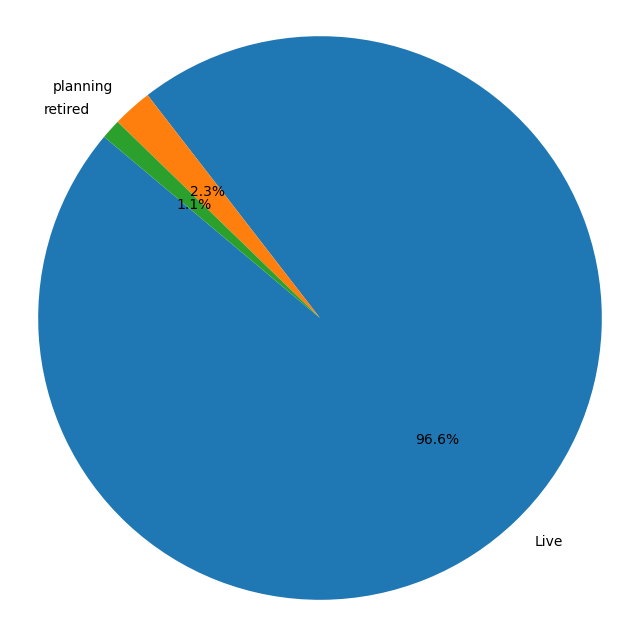

In [50]:
ask_rta_bot('Plot Pie chart of Status')

 
Role: Act as a data analyst whose job is extract insights from the dataset based on the users asked question.

Task: Write a valid python script for the below mentioned "user_question". Load "finalised.csv" only for querying the data.

user_question: Plot Bar graph of Status

"finalised.csv"  pandas columns names and their types: {"Name": "object", "Short Name": "object", "Description": "object", "Business Owner": "category", "Technical Owner": "category", "Number of Users": "object", "Recovery Point Objective": "object", "Recovery Time Objective": "object", "Go Live Date": "datetime64[ns]", "End of Support Date": "datetime64[ns]", "SLA Type": "category", "Vendor": "category", "Status": "category", "AGF Classification": "category", "DR Type": "category", "Required Availability": "category", "System Hosting Place": "category", "User Community": "category", "Type of System": "category", "Enterprise Level": "category", "Development Type": "category", "Recommendation": "category", "Cloud

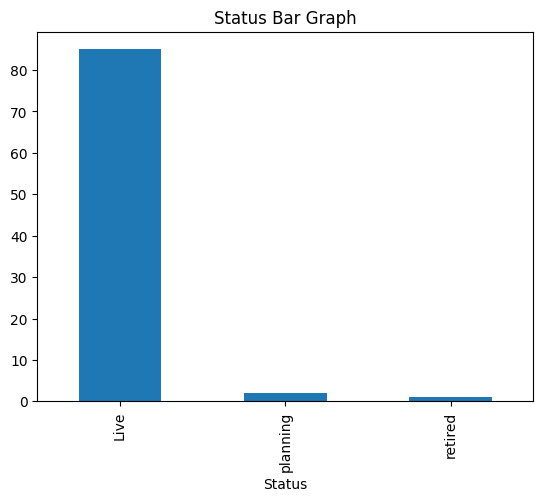

In [51]:
ask_rta_bot('Plot Bar graph of Status')